<a href="https://colab.research.google.com/github/congruent352/GAN/blob/main/Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Term Project**<a name="contents"></a>

**[1. Import the libraries](#1)**

**[2. Load the data](#2)**

**[3. Build a CycleGAN & Edge detection & Discriminator](#3)**

- [Generator](#3.1)

- [Discriminator](#3.2)

- [Initialization](#3.3)

- [CycleGAN](#3.3)


**[4. Train](#4)**

**[5. Test](#5)**

## **[Import the libraries](#contents)<a name="1"></a>**

In [ ]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
plt.rcParams['figure.figsize'] = [12, 6]

from google.colab import drive
drive.mount('/content/drive')

# path to PET scans
path1 = '/content/drive/MyDrive/Coursework/Machine Learning/GAN/PET Scans/1 (' 

# path to CT scans
path2 = '/content/drive/MyDrive/Coursework/Machine Learning/GAN/CT Scans/1 (' 

# path to the pretrained weights
PATH = 'drive/My Drive/GAN'

Mounted at /content/drive


## **[Load the data](#contents)<a name ="2"></a>**

We decide not to use the validation, as we have small number of samples.

* First, the filename extension is **dcm**, so we downloaded **pydicom**.


In [ ]:
!pip install pydicom
import pydicom
import cv2
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image
from numpy import asarray


PET_images = []


for i in range(419):
  slice = pydicom.read_file(path1 + str(i+1) + ').dcm')
  #s = int(slice.RescaleSlope)
  #b = int(slice.RescaleIntercept)
  image = np.array(slice.pixel_array)
  PET_images.append(image)

PET_images = torch.FloatTensor(PET_images)


CT_images = []
for i in range(696):
  image_pil = Image.open(path2 + str(i+1) + ').png')
  image = asarray(image_pil)
  CT_images.append(image)

CT_images = torch.FloatTensor(CT_images)

In [ ]:
# Normalization

PET_scale = torch.max(PET_images) - torch.min(PET_images)
PET_intercept = torch.min(PET_images) * torch.ones_like(PET_images)
CT_scale = torch.max(CT_images) - torch.min(CT_images)
CT_intercept = torch.min(CT_images) * torch.ones_like(CT_images)

PET_images = (PET_images - PET_intercept ) / (PET_scale)
CT_images = (CT_images - CT_intercept ) / (CT_scale)

kernel = torch.FloatTensor([[-1, -1, -1],
                                        [-1, 8.5, -1],
                                        [-1, -1, -1]]).view([1, 1, 3, 3])
EdgeDetection = nn.Conv2d(1, 1, 3, 1, 1, bias = False)
EdgeDetection.weight = nn.Parameter(kernel, requires_grad = False)

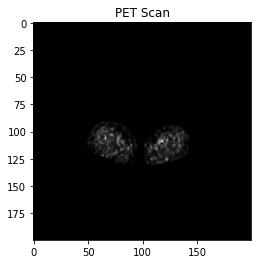

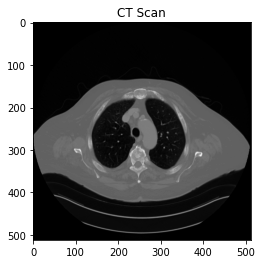

In [ ]:
plt.imshow(PET_images[0], cmap = 'gray')
plt.title('PET Scan')
plt.show()
plt.imshow(CT_images[0], cmap = 'gray')
plt.title('CT Scan')
plt.show()

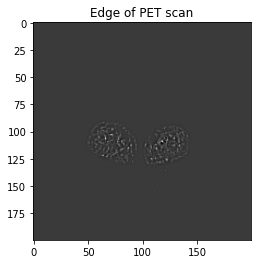

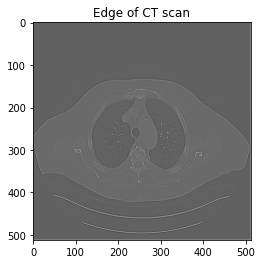

In [ ]:
a = EdgeDetection(PET_images.view(-1, 1, 200, 200))
b = EdgeDetection(CT_images.view(-1, 1, 512, 512))

plt.imshow(a[0].reshape(200, 200), cmap = 'gray')
plt.title('Edge of PET scan')
plt.show()
plt.imshow(b[0].reshape(512, 512), cmap = 'gray')
plt.title('Edge of CT scan')
plt.show()

## **[Construct the models](#contents)<a name = "3"></a>**

### **Generator**<a name = "3.1"></a>

Here, we are going to build three generators for comparison.

1. **Cycle GAN**
$$ \text{PET Scans} \rightleftharpoons \text{CT Scans}$$

2. **Cycle MedGAN**
$$ \text{perceptual, style losses}\leftarrow \text{PET Scans} \rightleftharpoons \text{CT Scans} \to\text{perceptual, style losses} $$

3. **Our approach**
$$\text{Edge Detection}\leftarrow\text{PET Scans} \rightleftharpoons \text{CT Scans}\to \text{Edge Detection}$$

and vice versa.



### **Structure?**

* PET Scan: 200$\times$200

  CT Scan: 512$\times$512

* $G_1$ (CT Generator): PET Scan $\to$ Down Sampling (4, 4, 4) $\to$ Up Sampling (512, 512)

  $G_2$ (PET Generator): CT Scan $\to$ Down Sampling (4, 4, 4) $\to$ Up Sampling (200, 200)

* $D_1$ (PET Discriminator): PET Scan $\to$ Down Sampling (4, 4, 4) $\to$ Dense Neural Network $\to$ (1)

  $D_2$ (CT Discriminator): CT Scan $\to$ Down Sampling (4, 4, 4) $\to$ Dense Neural Network $\to$ (1)




In [ ]:
class CT_generator(nn.Module):
    def __init__(self):
        super(CT_generator, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(16, 8, 5, 3, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 4, 4, 2, 1),
            nn.Tanh(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(4, 8, 4, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = input.view(-1, 16, 50, 50)
        x = self.conv(x)
        x = self.deconv(x)
        x = x.reshape(-1, 512, 512)
        return x

class PET_generator(nn.Module):
    def __init__(self):
        super(PET_generator, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(16, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 4, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 4, 4, 2, 1),
            nn.Tanh(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(4, 8, 4, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 1, 4, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = input.view(-1, 16, 128, 128)
        x = self.conv(x)
        x = self.deconv(x)
        x = x.reshape(-1, 200, 200)
        return x

## **[Construct the discriminators](#contents)<a name="3.2"></a>**



In [ ]:
class PET_discriminator(nn.Module):
    def __init__(self):
        super(PET_discriminator, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(16, 8, 5, 3, 1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 4, 4, 2, 1),
            nn.LeakyReLU(0.2),
        )

        self.fc = nn.Sequential(
            nn.Linear(4*4*4, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = input
        x = x.view(-1, 16, 50, 50)
        x = self.conv(x)
        x = x.view(-1, 4*4*4)
        x = self.fc(x)

        return x



class CT_discriminator(nn.Module):
    def __init__(self):
        super(CT_discriminator, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(16, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 4, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 4, 4, 2, 1),
            nn.Tanh(),
        )

        self.fc = nn.Sequential(
            nn.Linear(4*4*4, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = input
        x = input.view(-1, 16, 128, 128)
        x = self.conv(x)
        x = x.view(-1, 4*4*4)
        x = self.fc(x)

        return x


## **[Initialization](#contents)<a name = "3.3"></a>**

**[Types of Initializations](https://prateekvishnu.medium.com/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528)**

1. He Initialization

2. Xavier Initialization

3. Random Initialization

In [ ]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

## **[CycleGAN & Edge Detection](#contents)<a name = "3.4"></a>**

**Loss function** consists of four parts
> 1. Loss from discriminator (Binary Cross Entropy loss)
>
> 2. Loss to fool discriminator (Binary Cross Entropy loss)
>
> 3. Cycle Consistency (MSE loss)
>
> 4. Cycle Consistency of Edge (MSE loss)

In [ ]:
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        #self.batch_size = params['batch_size']
        self.inner_train = params['inner_train']

        # load dataset
        # self.data_loader1 = torch.utils.data.DataLoader(PET_images, 
        #                                       batch_size=self.batch_size, 
        #                                       shuffle=True)
        # self.data_loader2 = torch.utils.data.DataLoader(CT_images, 
        #                                       batch_size=self.batch_size, 
        #                                       shuffle=True)
        # data1 = self.data_loader1.__iter__().__next__()[0]
        # data2 = self.data_loader2.__iter__().__next__()[0]
        self.PET = PET_images.cuda()
        self.CT = CT_images.cuda()

        kernel = torch.FloatTensor([[-1, -1, -1],
                                        [-1, 8.5, -1],
                                        [-1, -1, -1]]).view([1, 1, 3, 3])
        self.kernel = kernel.cuda()
        self.EdgeDetection = nn.Conv2d(1, 1, 3, 1, 1, bias = False)
        self.EdgeDetection.weight = nn.Parameter(self.kernel, requires_grad = False)

        # initialization of the generator and discriminator
        # G1 maps PET to CT
        # G2 maps CT to PET
        # D1 is a discriminator on PET
        # D2 is a discriminator on CT
        self.G1 = CT_generator().cuda()
        self.G2 = PET_generator().cuda()
        self.D1 = PET_discriminator().cuda()
        self.D2 = CT_discriminator().cuda()
        self.G1_optimizer = optim.Adam(self.G1.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.G2_optimizer = optim.Adam(self.G2.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.D1_optimizer = optim.Adam(self.D1.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']))
        self.D2_optimizer = optim.Adam(self.D2.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']))
        
        # initialization of the loss function

        self.BCE_loss = nn.BCELoss().cuda()
        self.MSE_loss = nn.MSELoss().cuda()
        
        # Gettng a batch of noise to generate the fake data
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        self.train_hist = {}
        self.train_hist['D1_loss'] = []
        self.train_hist['G1_loss'] = []
        self.train_hist['D2_loss'] = []
        self.train_hist['G2_loss'] = []

        # Setting up the labels for real and fake images
        self.PET_real = torch.ones(419, 1).cuda()
        self.PET_fake = torch.zeros(696, 1).cuda()
        self.CT_real = torch.ones(696, 1).cuda()
        self.CT_fake = torch.zeros(419, 1).cuda()
        
        print('training start!!')

        # Epoch loops

        t1 = time.time()

        for epoch in range(self.epoch):
            
            
            

            # D2        

            for i in range(self.inner_train):
                  self.D2_optimizer.zero_grad()
                  CT_real = self.D2(self.CT)
                  CT_real_loss = self.BCE_loss(CT_real, self.CT_real)
                  CT_fake = self.D2(self.G1(self.PET))
                  CT_fake_loss = self.BCE_loss(CT_fake, self.CT_fake)

                  D2_loss = CT_real_loss + CT_fake_loss
                  D2_loss.backward()
                  self.D2_optimizer.step()


            # D1

            for i in range(self.inner_train):
                  self.D1_optimizer.zero_grad()
                  PET_real = self.D1(self.PET)
                  PET_real_loss = self.BCE_loss(PET_real, self.PET_real)
                  PET_fake = self.D1(self.G2(self.CT))
                  PET_fake_loss = self.BCE_loss(PET_fake, self.PET_fake)

                  D1_loss = PET_real_loss + PET_fake_loss
                  D1_loss.backward()
                  self.D1_optimizer.step()

            # G1

            for i in range(self.inner_train):
                  self.G1_optimizer.zero_grad()
                  PET_fake = self.D1(self.G2(self.CT))
                  PET_fake_loss = self.BCE_loss(PET_fake, self.CT_real)
                  PET_cycle = self.G2(self.G1(self.PET))
                  PET_cycle_loss = self.MSE_loss(PET_cycle, self.PET)

                  PET_edge = self.EdgeDetection(self.PET.view(-1, 1, 200, 200))
                  PET_edge_cycle = self.EdgeDetection(PET_cycle.view(-1, 1, 200, 200))
                  PET_edge_loss = self.MSE_loss(PET_edge, PET_edge_cycle)

                  G1_loss = PET_fake_loss + PET_cycle_loss + PET_edge_loss/10
                  G1_loss.backward()
                  self.G1_optimizer.step()
                  G1_loss = PET_fake_loss + PET_cycle_loss

            # G2

            for i in range(self.inner_train):
                  self.G2_optimizer.zero_grad()
                  CT_fake = self.D2(self.G1(self.PET))
                  CT_fake_loss = self.BCE_loss(CT_fake, self.PET_real)
                  CT_cycle = self.G1(self.G2(self.CT))
                  CT_cycle_loss = self.MSE_loss(CT_cycle, self.CT)

                  CT_edge = self.EdgeDetection(self.CT.view(-1, 1, 512, 512))
                  CT_edge_cycle = self.EdgeDetection(CT_cycle.view(-1, 1, 512, 512))
                  CT_edge_loss = self.MSE_loss(CT_edge, CT_edge_cycle)

                  G2_loss = CT_fake_loss + CT_cycle_loss + CT_edge_loss/10
                  G2_loss.backward()
                  self.G2_optimizer.step()
                  G2_loss = CT_fake_loss + CT_cycle_loss

            # Edge Detection




            if epoch%100 == 0:
                  torch.save(self.G1.state_dict(), PATH + 'G1.pth')
                  torch.save(self.G2.state_dict(), PATH + 'G2.pth')
                  torch.save(self.D1.state_dict(), PATH + 'D1.pth')
                  torch.save(self.D2.state_dict(), PATH + 'D2.pth')
                  print("Epoch : {0}/{1}".format(epoch, self.epoch))

                  print("G1 Loss = ", G1_loss)
                  print("G2 Loss = ", G2_loss)
                  print("D1 Loss = ", D1_loss)
                  print("D2 Loss = ", D2_loss)
                  



##########################################################################

                

            self.train_hist['D1_loss'].append(D1_loss.item())
            self.train_hist['G1_loss'].append(G1_loss.item())
            self.train_hist['D2_loss'].append(D2_loss.item())
            self.train_hist['G2_loss'].append(G2_loss.item())


        print("Training finished!")
        t2 = time.time()
        print(t2 - t1)

## **[Training](#contents)<a name ="4"></a>**

In [ ]:
params = {'beta1': 0.5, 'beta2': 0.999,'lr_g':0.05, 'lr_d':0.002,'max_epochs':10000, 'inner_train':10}

gan = GAN(params)
gan.train()

## **[Test](#contents)**<a name = "5"></a>

Since we do not have a paired dataset, we are not able to compare the results quantitatively. Though not perfect, we have to compare the results 

In [ ]:
path = '/content/drive/MyDrive/GAN'
G1 = CT_generator()
w = torch.load(path + 'G1.pth')
G1.load_state_dict(w)

<All keys matched successfully>

In [ ]:
CT_fake = G1(PET_images)
CT_fake.shape

torch.Size([696, 200, 200])

In [ ]:
for i in range(10):
  a = CT_fake[i].detach().numpy()
  plt.imshow(a, cmap = 'gray')
  plt.show()

In [ ]:
for i in range(419):
  a = CT_fake[i].detach().numpy()
  plt.imshow(a, cmap = 'gray')
  plt.show()